## 0. Scan Parameters and Initialization ##

In [1]:
%matplotlib inline  
%pylab
%matplotlib inline  


Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.io import loadmat, savemat
from util import mosaic, status_check
import matplotlib.pyplot as plt
from numpy.ma import masked_array
from skimage.filters import threshold_otsu
import time
import dcemri

# SCRIPT FLAGS
plotting = True

# SCAN PARAMETERS
flip = pi * 20.0  / 180.0 # deg
TR = 7.939e-3   # s
TE = 4.6e-3 # s
Rel = 4.5   # Relaxivity of Gd-DTPA at 3T [ms^-1 [mmol Gd-DTPA]^{-1}]   
scan_time = 16.42   # s
SNR = 15.0   # assumed for now, but can measure

In [3]:
mpl.cm.register_cmap(name='cubehelix3', data=mpl._cm.cubehelix(gamma=1.0, s=0.4, r=-0.5, h=1.5))

## 1. Load population-averaged arterial input function (AIF) ##

In [4]:
mat = loadmat('invivo/AIF.mat')
y_aif = mat['data'].flatten()
t_aif = mat['t'].flatten() / 60.0

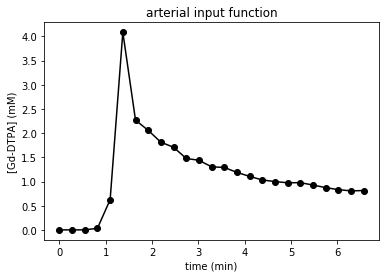

In [5]:
if plotting:
    figure(1)
    clf()
    plot(t_aif, y_aif, 'ko-')
    xlabel('time (min)')
    ylabel('[Gd-DTPA] (mM)')
    title('arterial input function')
    savefig('invivo/aif.pdf')

## Load DCE and T1 multiflip data ##

In [6]:
mat = loadmat('invivo/data_t1.mat')
data_t1 = mat['data']
t1_flip_angles = mat['flip']
mat = loadmat('invivo/data_dce.mat')
data_dce = mat['data']
t_dce = mat['t']
nx, ny, nt = data_dce.shape

In [7]:
mat = loadmat('invivo/mask.mat')
mask = mat['mask']

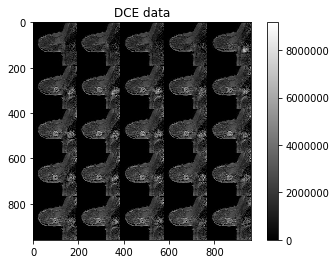

In [8]:
if plotting:
    figure(2)
    clf()
    imshow(mosaic(transpose(data_dce,(2,0,1))), interpolation='nearest', cmap='gray')
    colorbar()
    title('DCE data')
    savefig('invivo/dcedata.pdf')

In [9]:
#snr_mask = data_dce[:,:,0] > 1e-2 * data_dce.max()
SNR, snr_mask = dcemri.signal_to_noise_ratio(data_dce[:,:,0], data_dce[:,:,1])
print ('DCE SNR: ' + str(SNR))
mask_dce = data_dce[:,:,0] > (1.0 / SNR)*data_dce.max()

computing signal-to-noise ratio
DCE SNR: 6.22407844642


In [10]:
SER = reshape(dcemri.signal_enhancement_ratio(data_dce), (nx, ny))

computing signal enhancement ratios


/home/aydin/.local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


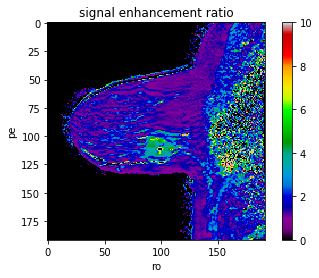

In [11]:
if plotting:
    figure(3)
    clf()
    imshow(SER, interpolation='nearest', cmap='spectral', vmax=10)
    colorbar()
    title('signal enhancement ratio')
    xlabel('ro')
    ylabel('pe')
    savefig('invivo/ser.pdf')

In [12]:
nt = data_dce.shape[-1]
data_dce = reshape(data_dce, (-1, nt))
nx, ny, nflip = data_t1.shape
data_t1 = reshape(data_t1, (nx*ny, nflip))
# Time vector for DCE data in minutes
t_dce = arange(nt)*scan_time / 60.0

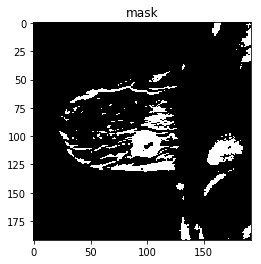

In [13]:
if plotting:
    figure(4)
    imshow(mask, interpolation='nearest', cmap='gray')
    title('mask')
    savefig('invivo/mask.pdf')

## Make a T1 map ##

In [14]:
import imp
dcemri = imp.reload(dcemri)
t1_flip_angles = pi*arange(20,0,-2)/180.0
R1map, S0map, covmap = dcemri.fit_R1(data_t1, t1_flip_angles, TR) 

100%|██████████| 36864/36864 [00:13<00:00, 2796.70it/s]


In [15]:
covmap = reshape(covmap, (nx, ny, 4))

In [16]:
# create a processing mask from the T1 map
r1mask = logical_and(R1map < 10, R1map > 0).flatten() 
R1map[~r1mask] = 0

/home/aydin/.local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


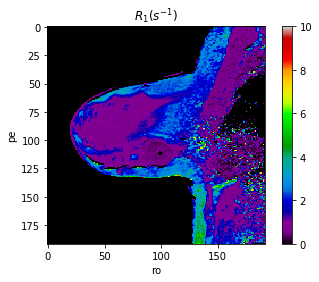

In [17]:
if plotting:
    figure(4)
    clf()
    title('$R_1 (s^{-1})$')
    imshow(reshape(R1map, (nx, ny)), interpolation='nearest', cmap='spectral', vmax=10)
    xlabel('ro')
    ylabel('pe')
    colorbar()
    savefig('invivo/r1map.pdf')

/home/aydin/.local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


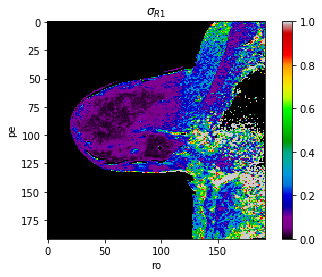

In [18]:
if plotting:
    figure(5)
    clf()
    imshow((sqrt(covmap[:,:,3])), interpolation='nearest', cmap='spectral', vmax=1)
    title('$\sigma_{R1}$')
    xlabel('ro')
    ylabel('pe')
    colorbar()
    savefig('invivo/sigmar1.pdf')

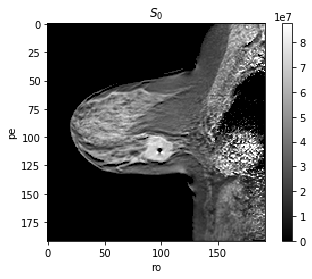

In [19]:
if plotting:
    figure(6)
    clf()
    imshow(reshape(S0map, (nx, ny)), interpolation='nearest', cmap='gray', vmax = mean(S0map) + 3*std(S0map))
    title('$S_0$')
    xlabel('ro')
    ylabel('pe')
    colorbar()
    savefig('invivo/s0map.pdf')

## Convert DCE data to tissue concentration $C_t$ ##

In [20]:
mask.shape
idxs = find(mask.flatten())
idxs = range(nx*ny)

In [21]:
import imp
dcemri = imp.reload(dcemri)
S0 = data_dce[:,:5].mean()
R1_eff = dcemri.dce_to_r1eff(data_dce, S0, R1map.flatten(), TR, flip)
data_dce = reshape(data_dce, (-1, nt))
R1_eff_old = dcemri.dce_to_r1eff_old(data_dce, S0map.flatten(), list(idxs), TR, flip)
data_dce = reshape(data_dce, (nx, ny, nt))

converting DCE signal to effective R1


/home/aydin/uke/projects/dcemri/3rd/own/pydcemri/dcemri.py:82: RuntimeWarning: invalid value encountered in log
  R = (-1.0 / TR) * log(E)
/home/aydin/uke/projects/dcemri/3rd/own/pydcemri/dcemri.py:90: RuntimeWarning: divide by zero encountered in true_divide
  T[idxs,:] = (S[idxs,:].T / S0map.flat[idxs] / sin(flip)).T # normalize by pre-contrast signal
/home/aydin/uke/projects/dcemri/3rd/own/pydcemri/dcemri.py:90: RuntimeWarning: invalid value encountered in true_divide
  T[idxs,:] = (S[idxs,:].T / S0map.flat[idxs] / sin(flip)).T # normalize by pre-contrast signal
/home/aydin/uke/projects/dcemri/3rd/own/pydcemri/dcemri.py:92: RuntimeWarning: invalid value encountered in true_divide
  R1[idxs,:] = -log( (T[idxs,:] - 1) / (T[idxs,:]*cos(flip) - 1) ) / TR
/home/aydin/uke/projects/dcemri/3rd/own/pydcemri/dcemri.py:92: RuntimeWarning: invalid value encountered in log
  R1[idxs,:] = -log( (T[idxs,:] - 1) / (T[idxs,:]*cos(flip) - 1) ) / TR


/home/aydin/.local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


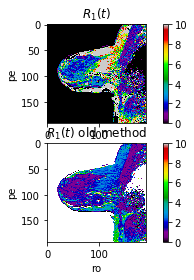

In [22]:
# show map of R1_eff 
R1_eff = reshape(R1_eff, (nx, ny, nt))
R1_eff_old = reshape(R1_eff_old, (nx, ny, nt))
if plotting:
    figure(7)
    clf()
    subplot(211)
    imshow(mosaic(R1_eff[:,:,-1]), interpolation='nearest', cmap='spectral', vmin=0, vmax=10)
    title('$R_1(t)$')
    xlabel('ro')
    ylabel('pe')
    colorbar()
    subplot(212)
    imshow(mosaic(R1_eff_old[:,:,-1]), interpolation='nearest', cmap='spectral', vmin=0, vmax=10)
    title('$R_1(t)$ old method')
    xlabel('ro')
    ylabel('pe')
    colorbar()
    R1_eff = reshape(R1_eff, (-1, nt))
    R1_eff_old = reshape(R1_eff_old, (-1, nt))

In [23]:
# convert effecitve R1 to tissue concentration Ct
#Ct = ((R1_eff.T - R1map.flatten()).T) / Rel
Ct = dcemri.r1eff_to_conc(R1_eff_old.T, R1map, Rel).T
Ct.shape

converting effective R1 to tracer tissue concentration


(36864, 25)

/home/aydin/.local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


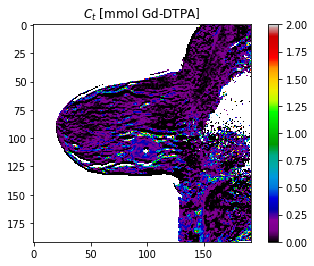

In [24]:
# show map of Ct
Ct = reshape(Ct, (nx, ny, nt))
if plotting:
    figure(9)
    clf()
    imshow(Ct[:,:,-1], interpolation='nearest', cmap='spectral', vmin=0, vmax=2)
    title('$C_t$ [mmol Gd-DTPA]')
    colorbar()
    savefig('invivo/Ct.pdf')
Ct = reshape(Ct, (-1, nt))

## Fit voxel-wise $C_t$ to the model to get $K^{trans}$, $v_e$, and $v_p$ ##

In [25]:
import imp
dcemri = imp.reload(dcemri)


In [26]:
mask_dce = zeros((nx, ny))
mask = reshape(mask, (nx, ny))
mask_dce[90:120, 80:120] = True
mask_dce = logical_and(mask, mask_dce) #logical_and(Ct[:,-1] > 0.5, Ct[:,-1] < 0.8)
idxs = find(mask_dce)
print ('--fitting ' +str(len(idxs)) + ' voxels')
params, covs = dcemri.fit_tofts_model(Ct, y_aif, t_dce, idxs, extended=False, plot_each_fit=False)

--fitting 733 voxels
fitting perfusion parameters
using Standard Tofts-Kety
fitting 733 voxels


/home/aydin/uke/projects/dcemri/3rd/own/pydcemri/dcemri.py:127: RuntimeWarning: overflow encountered in exp
  tmp = cumtrapz(exp(-(Kt/ve)*(t[k] - t[:k+1]))*Cp[:k+1],
/home/aydin/uke/projects/dcemri/3rd/own/pydcemri/dcemri.py:127: RuntimeWarning: invalid value encountered in multiply
  tmp = cumtrapz(exp(-(Kt/ve)*(t[k] - t[:k+1]))*Cp[:k+1],
/home/aydin/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


10% complete, 24 of 27 s remain
20% complete, 21 of 27 s remain
30% complete, 16 of 24 s remain
40% complete, 14 of 23 s remain
50% complete, 12 of 24 s remain
60% complete, 9 of 23 s remain
70% complete, 6 of 21 s remain
80% complete, 4 of 21 s remain
90% complete, 2 of 20 s remain
100% complete, 0 of 20 s remain
20.784992694854736 s elapsed


In [27]:
#Kt = zeros(nx*ny)
#Kt[idxs] = params[0]
Kt = params[0]
#ve = zeros(nx*ny)
#ve[idxs] = params[1]
ve = params[1]
#Kt_std = zeros(nx*ny)
#Kt_std[idxs] = covs[0]
Kt_std = covs[0]
#ve_std = zeros(nx*ny)
#ve_std[idxs] = covs[1]
ve_std = covs[1]

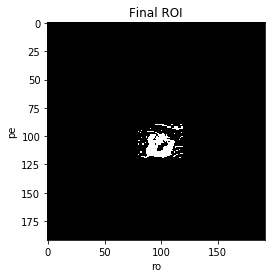

In [28]:
MAX_COV = 0.1

Kt = reshape(Kt, (nx, ny))
ve = reshape(ve, (nx, ny))
#vp = reshape(vp, (nx, ny))
Kt_std = reshape(Kt_std, (nx, ny))
ve_std = reshape(ve_std, (nx, ny))
#vp_std = reshape(vp_std, (nx, ny))
mask_params = logical_or(logical_or(Kt <= 0.0, ve <= 0.0), ve > 1.0)
#mask = logical_or(logical_or(logical_or(logical_or(Kt <= 0.0, ve <= 0.0), vp <= 0.0), ve > 1.0), vp > 1.0)
#mask_params = ~logical_and(~mask_params, reshape(mask_dce, (nx, ny)))
mask_params = logical_or(logical_or(mask_params, ve_std > MAX_COV), Kt_std > MAX_COV)

if plotting:
    figure(12)
    clf()
    imshow(~mask_params, interpolation='nearest', cmap='gray')
    xlabel('ro')
    ylabel('pe')
    title('Final ROI')
    savefig('mask_dce.pdf')

In [29]:
data_dce.shape

(192, 192, 25)

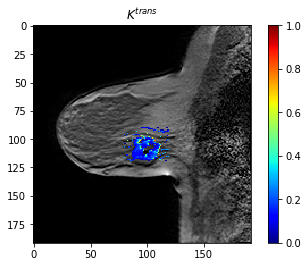

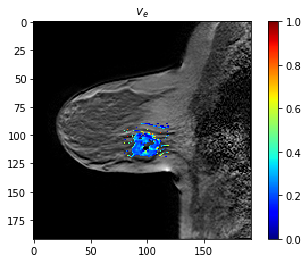

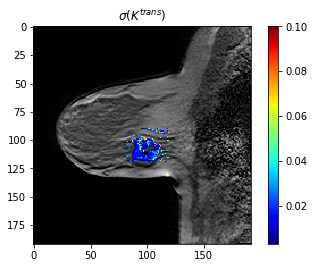

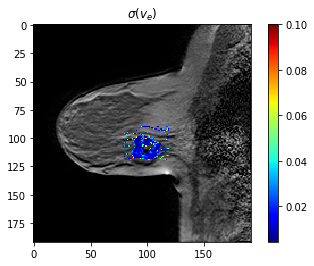

In [30]:
# PLOT DCE RESULTS

x = masked_array(reshape(data_dce[:,:,0],(nx,ny)), ~mask_params)

figure(13)
clf()
y = masked_array(Kt, mask_params)
imshow(x, interpolation='nearest', cmap='gray')
imshow(y, interpolation='nearest', cmap='jet', vmin=0, vmax=1)
colorbar()
title('$K^{trans}$')
savefig('invivo/ktrans.pdf')


figure(14)
clf()
y = masked_array(ve, mask_params)
imshow(x, interpolation='nearest', cmap='gray')
imshow(y, interpolation='nearest', cmap='jet', vmin=0, vmax=1)
title('$v_e$')
colorbar()
savefig('invivo/ve.pdf')

figure(15)
clf()
y = masked_array(Kt_std, mask_params)
imshow(x, interpolation='nearest', cmap='gray')
imshow(y, interpolation='nearest', cmap='jet',vmax=MAX_COV)
title('$\sigma(K^{trans})$')
colorbar()
savefig('invivo/ktrans_std.pdf')

figure(16)
clf()
y = masked_array(ve_std, mask_params)
imshow(x, interpolation='nearest', cmap='gray')
imshow(y, interpolation='nearest', cmap='jet',vmax=MAX_COV)
title('$\sigma(v_e)$')
colorbar()
savefig('invivo/ve_std.pdf')


In [31]:
out_mat = {}
out_mat['ve'] = ve
out_mat['Kt'] = Kt
out_mat['Kt_std'] = Kt_std
out_mat['ve_std'] = ve
out_mat['mask'] = mask.astype('int')
out_mat['R1map'] = reshape(R1map, (nx, ny))
out_mat['S0map'] = reshape(S0map, (nx, ny))
savemat('invivo/out_trap.mat', out_mat)